In [1]:
import os
#s.environ['CDF_LIB'] = '/home/ranhao/codes/cdf39_0-dist/lib'

from spacepy import pycdf
import numpy as np
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
import cdflib
import astropy.constants as const
import astropy
from datetime import datetime, timedelta
import scipy
from scipy import interpolate
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema, savgol_filter
import bisect
import pickle

from Funcs import *
from SolarWindPack import *

In [2]:
def OneParticleNoiseLevel(count_cdffile, vdffile):
    
    # For all the measurement of the day
    vdf = vdffile['vdf'][...] # Extract all the vdf
    vdf_epochs = np.array(vdffile['Epoch'], dtype="datetime64[ms]") # Extract all the epochs, convert to np.array for quicker search.
    counts = count_cdffile['COUNTS'][...] # Extract all the counts
    count_epochs = np.array(count_cdffile['Epoch'], dtype="datetime64[ms]") # Extract all the epochs

    adjusted_vdf_times = vdf_epochs - np.timedelta64(500, 'ms') # Adjust the vdf times to match the counts times
    match_indices = np.searchsorted(count_epochs, adjusted_vdf_times) # Find the indices of the counts that match the vdf times
    counts = counts[match_indices] # Get the counts that match the vdf times

    noise_level = np.divide(vdf, counts, out=np.zeros_like(vdf, dtype=float), where=counts != 0) # Calculate the noise level
    noise_level[np.isnan(noise_level)] = 0 # Drop the NaN values and replace them with 0.
    one_particle_noise_level = np.nanpercentile(noise_level, 99.9, axis=0)

    return one_particle_noise_level

In [3]:
yymmdd = '20230319'
data_list = os.listdir(f'data/SO/{yymmdd}')

vdf_fname = next(file for file in data_list if 'pas-vdf' in file and not file.startswith('._'))
grnd_fname = next(file for file in data_list if 'pas-grnd-mom' in file and not file.startswith('._'))
mag_fname = next(file for file in data_list if 'mag-srf-normal' in file and not file.startswith('._'))
eflux_fname = next(file for file in data_list if 'pas-eflux' in file and not file.startswith('._'))
count_fname = next(file for file in data_list if 'pas-3d' in file and not file.startswith('._'))

vdf_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{vdf_fname}')
grnd_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{grnd_fname}')
mag_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{mag_fname}')
eflux_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{eflux_fname}')
count_cdffile = pycdf.CDF(f'data/SO/{yymmdd}/{count_fname}')

In [4]:
#one_particle_noise_level = OneParticleNoiseLevel(count_cdffile, vdf_cdffile)
#np.savez(f'result/SO/{yymmdd}/one_particle_noise_level.npz', noise_level=one_particle_noise_level)

loaded_data = np.load(f'result/SO/{yymmdd}/one_particle_noise_level.npz')
one_particle_noise_level = loaded_data['noise_level']

In [5]:
# Get the first initial value.
timeslice = datetime(2023, 3, 19, 12, 8, 38)
yymmdd = timeslice.strftime("%Y%m%d")
hhmmss = timeslice.strftime("%H%M%S")
epoch_vdf = vdf_cdffile['Epoch'][...]
epoch_mag = mag_cdffile['EPOCH'][...]

tsliceindex_vdf = bisect.bisect_left(epoch_vdf, timeslice)
measured_time = epoch_vdf[tsliceindex_vdf]
print('Time for VDF: ', measured_time)
print("Time index for VDF: ", tsliceindex_vdf)

# Average the B field within the following timerange to get the B field.
tslice_vdf_start = epoch_vdf[tsliceindex_vdf] - timedelta(seconds=0.5)
tslice_vdf_end = epoch_vdf[tsliceindex_vdf] + timedelta(seconds=0.5)
tsliceindex_mag_start = bisect.bisect_left(epoch_mag, tslice_vdf_start)
tsliceindex_mag_end = bisect.bisect_left(epoch_mag, tslice_vdf_end)
print('Time for MAG: ', epoch_mag[tsliceindex_mag_start], " to ", epoch_mag[tsliceindex_mag_end])
print("Time index for MAG: ", tsliceindex_mag_start, " to ", tsliceindex_mag_end)

# Read data from SO product.
V_bulk_SRF = grnd_cdffile['V_SRF'][tsliceindex_vdf]
vdf = vdf_cdffile['vdf'][tsliceindex_vdf]

qp = 1.60217662e-19 # C
mp = 1.6726219e-27 # kg

vel = np.sqrt(2 * vdf_cdffile['Energy'][...] * qp / mp) / 1e3 * (u.km / u.s) # in km/s
theta = vdf_cdffile['Elevation'][...] * u.deg # in deg
phi = vdf_cdffile['Azimuth'][...] * u.deg # in deg

magF_SRF = mag_cdffile['B_SRF'][tsliceindex_mag_start:tsliceindex_mag_end].mean(axis=0)
print('Magnetic feild in SRF: ', magF_SRF)

# Calculate the local Alfven speed to set initial means.
B_magnitude = np.sqrt(np.sum(magF_SRF**2)) * 1e-9  #T
density = grnd_cdffile['N'][tsliceindex_vdf] * 1e6 # m^-3
mu0 = 4 * np.pi * 1e-7 # N/A^2
mp = 1.67*1e-27 # kg

VA = B_magnitude / np.sqrt(mu0 * density * mp) / 1000.0 #  km/s
print('Local Alfven speed: ', VA)

# Consider the one-particel noise level.
print(vdf.shape)
print(one_particle_noise_level.shape)

# Any anode with measurement below the noise level is considered as noise, and removed.
vdf_corrected = vdf.copy()
vdf_corrected[vdf_corrected <= one_particle_noise_level] = 0

print("Before one-particel noise level: ", np.count_nonzero(vdf))
print("After one-particel noise level: ", np.count_nonzero(vdf_corrected))

# Let's first get the f and (vx, vy, vz) grid points.
vx = np.zeros((11, 9, 96))
vy = np.zeros((11, 9, 96))
vz = np.zeros((11, 9, 96))

# Calculate in SRF coordinate, proton bulk frame.
for i in range(11):
    for j in range(9):
        vx[i, j, :] = - vel * np.cos(theta[j]) * np.cos(phi[i]) - V_bulk_SRF[0] * u.km / u.s
        vy[i, j, :] = vel * np.cos(theta[j]) * np.sin(phi[i]) - V_bulk_SRF[1] * u.km / u.s
        vz[i, j, :] = - vel * np.sin(theta[j]) - V_bulk_SRF[2] * u.km / u.s

(Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz) = fieldAlignedCoordinates(magF_SRF[0], magF_SRF[1], magF_SRF[2])
(V_para, V_perp1, V_perp2) = rotateVectorIntoFieldAligned(vx, vy, vz, Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
(V_para_bulk, V_perp1_bulk, V_perp2_bulk) = rotateVectorIntoFieldAligned(V_bulk_SRF[0], V_bulk_SRF[1], V_bulk_SRF[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
V_perp = np.sqrt(V_perp1**2 + V_perp2**2)
print('V_bulk_field_aligned: ', V_para_bulk, V_perp1_bulk, V_perp2_bulk)

Time for VDF:  2023-03-19 12:08:38.987975
Time index for VDF:  10778
Time for MAG:  2023-03-19 12:08:38.599279  to  2023-03-19 12:08:39.599284
Time index for MAG:  349751  to  349759
Magnetic feild in SRF:  [-11.064228   9.707525  -4.265928]
Local Alfven speed:  65.58024240152058
(11, 9, 96)
(11, 9, 96)
Before one-particel noise level:  1030
After one-particel noise level:  856
V_bulk_field_aligned:  472.71317 -198.03653 337.00278


In [6]:
#hhmmss = '0_initial'
result_path = f'result/SO/{yymmdd}/Particles/Ions/{hhmmss}'
if not os.path.exists(result_path):
    os.makedirs(result_path)

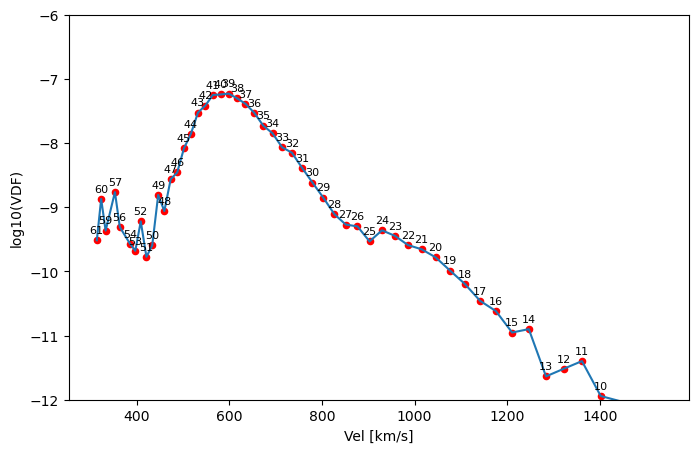

In [7]:
def log10_vdf(vdf):
    vdf = np.array(vdf)  # Ensure vdf is a NumPy array
    mask = vdf > 0  # Create a mask for positive values
    result = np.zeros_like(vdf)  # Initialize an array of zeros
    result[mask] = np.log10(vdf[mask])  # Compute log10 only for positive values
    return result

y = log10_vdf(np.sum(vdf_corrected, axis=(0, 1)))
mask = y != 0
x = vel[mask]
y = y[mask]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, y, label='Corrected VDF')
ax.scatter(x, y, s=20, color='red')
ax.set_ylim(-12, -6)
for idx, (xi, yi) in enumerate(zip(x.value, y)):
    ax.annotate(str(np.where(mask)[0][idx]), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
ax.set_xlabel('Vel [km/s]')
ax.set_ylabel('log10(VDF)')
plt.savefig(result_path + '/Corrected_VDF_1D.png')

In [8]:
def Remove_LowHigh_Speed_part(vdf_corrected, window_size=4, gap_limit=2):
    # Remove the low speed noise part.
    # vdf_corrected: vdf that is after one-particle noise level correction.
    # window size: how many succesive points of increasing can we consider as non_noise (low-speed), default 4.
    # gap_limit: how many points of gap can we consider as non_noise (low-speed), default 4.

    vdf_out = vdf_corrected.copy()
    data = np.sum(vdf_corrected, axis=(0, 1))
    y = log10_vdf(data)
    lower_speed_indice = len(data) - 1

    for i in range(len(data) - 1, window_size - 2, -1):  # Start from the end and move backward
        if all(data[j] < data[j - 1] for j in range(i, i - window_size + 1, -1)):  # Check for increases
            lower_speed_indice = i
            break
    vdf_out[:, :, lower_speed_indice:] = 0

    #IncreasingPoints = np.arange(lower_speed_indice - 1, lower_speed_indice - (window_size + 1), -1)[::-1]
    #Gaps = [np.abs(y[IncreasingPoints[i+1]] - y[IncreasingPoints[i]]) for i in range(len(IncreasingPoints)-1)][::-1]

    #for gap in Gaps:
    #   if gap > 0.5:
    #        lower_speed_indice -= 1

    data = np.sum(vdf_corrected, axis=(0, 1))
    mask = y != 0
    true_indexes = np.where(mask)[0][:10]

    higher_speed_indice = true_indexes[0]

    for i in range(len(true_indexes) - 1):
        # Check the gap bwtween successive points.
        if true_indexes[i+1] - true_indexes[i] > gap_limit:
            higher_speed_indice = true_indexes[i+1]
    
    vdf_out[:, :, :higher_speed_indice] = 0
    
    return vdf_out

vdf_2ndcorrected = Remove_LowHigh_Speed_part(vdf_corrected)

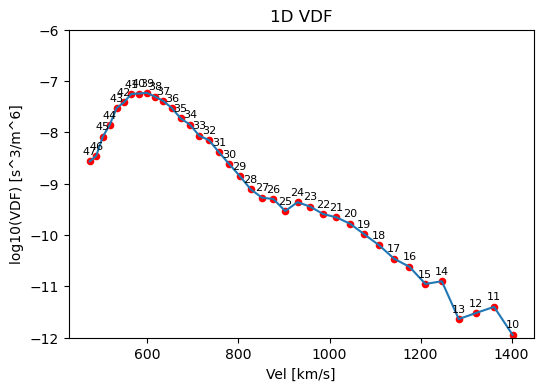

In [9]:
y = log10_vdf(np.sum(vdf_2ndcorrected, axis=(0, 1)))
mask = y != 0
x = vel[mask]
y = y[mask]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, label='Corrected VDF')
ax.scatter(x, y, s=20, color='red')
ax.set_ylim(-12, -6)
for idx, (xi, yi) in enumerate(zip(x.value, y)):
    ax.annotate(str(np.where(mask)[0][idx]), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
ax.set_xlabel('Vel [km/s]')
ax.set_ylabel('log10(VDF) [s^3/m^6]')
ax.set_title('1D VDF')
plt.savefig(result_path + '/Corrected_VDF_Cleaned.png')

In [10]:
dividing_idx = 25

In [11]:
# The dividing index between protons and alphas (Manually specified.).
f_proton = np.zeros_like(vdf_2ndcorrected)
f_proton[:, :, dividing_idx:] = vdf_2ndcorrected[:, :, dividing_idx:]
f_alpha = np.zeros_like(vdf_corrected)
f_alpha[:, :, :dividing_idx] = vdf_2ndcorrected[:, :, :dividing_idx]

# Mind here, grid is in the order of theta, phi, vel., and units are in deg, deg, m/s.
Protons_initial = SolarWindParticle('proton', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3], coord_type='Spherical')
Protons_initial.set_vdf(f_proton)

Alphas_initial = SolarWindParticle('alpha', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3], coord_type='Spherical')
Alphas_initial.set_vdf(f_alpha)

# Velocities
Vproton = cal_bulk_velocity_Spherical(Protons_initial)
Valpha = cal_bulk_velocity_Spherical(Alphas_initial)
Vproton_Baligned = rotateVectorIntoFieldAligned(Vproton[0], Vproton[1], Vproton[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
Valpha_Baligned = rotateVectorIntoFieldAligned(Valpha[0], Valpha[1], Valpha[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VprotonPara, VprotonPerp = Vproton_Baligned[0], np.sqrt(Vproton_Baligned[1]**2 + Vproton_Baligned[2]**2)
ValphaPara, ValphaPerp = Valpha_Baligned[0], np.sqrt(Valpha_Baligned[1]**2 + Valpha_Baligned[2]**2)

print(Protons_initial)
print(Alphas_initial)
print("Np: ", cal_density_Spherical(Protons_initial) / 1e6)
print("Moment density: ", density / 1e6)
print("Na: ", cal_density_Spherical(Alphas_initial) / 1e6)
print("Na / Np: ", cal_density_Spherical(Alphas_initial) / cal_density_Spherical(Protons_initial))
print("Vp: ", cal_bulk_velocity_Spherical(Protons_initial) / 1e3)
print("Va: ", cal_bulk_velocity_Spherical(Alphas_initial) / (1e3 * np.sqrt(2)))
print("Vp_Baligned: ", VprotonPara / 1e3, VprotonPerp / 1e3)
print("Va_Baligned: ", ValphaPara / (1e3 * np.sqrt(2)), ValphaPerp / (1e3 * np.sqrt(2)))
print("VA: ", VA)

Species = proton, Time = 2023-03-19 12:08:38.987975, Magnetic Field = [-11.064228   9.707525  -4.265928], VDF = single VDF set, Coordinate Grids Set in Spherical
Species = alpha, Time = 2023-03-19 12:08:38.987975, Magnetic Field = [-11.064228   9.707525  -4.265928], VDF = single VDF set, Coordinate Grids Set in Spherical
Np:  27.98362
Moment density:  26.02079963684082
Na:  0.470664875
Na / Np:  0.016819299111408746
Vp:  [-612.93384    38.291603  -17.266378]
Va:  [-705.04697913   69.61815947  -27.52043296]
Vp_Baligned:  471.5876 393.77332
Va_Baligned:  560.78950598465 433.83228412155427
VA:  65.58024240152058


In [12]:
diff_alpha_proton = (np.array(Valpha_Baligned) - np.array(Vproton_Baligned)) / 1e3
initial_means = np.array([
    [0, 0, 0, 0, Protons_initial.get_vdf().max()], 
    [VA, 0, 0, VA, Protons_initial.get_vdf().max() / 10.0],
    np.append(np.append(diff_alpha_proton, np.linalg.norm(diff_alpha_proton)), Alphas_initial.get_vdf().max())
])

In [16]:
def cal_GMM_first(V_para, V_perp1, V_perp2, vdf_corrected, co_type, initial_means, n_component):
    # Function for calculating GMM.
    non_zero_idx = np.where(vdf_corrected > 0)
    non_zero_vdf = vdf_corrected[non_zero_idx]
    non_zero_vpara = V_para[non_zero_idx]
    non_zero_vperp1 = V_perp1[non_zero_idx]
    non_zero_vperp2 = V_perp2[non_zero_idx]
    non_zero_magni = np.sqrt(non_zero_vpara**2 + non_zero_vperp1**2 + non_zero_vperp2**2)
    
    X = np.column_stack([non_zero_vpara, non_zero_vperp1, non_zero_vperp2, non_zero_magni, non_zero_vdf])

    # Use KMeans to determine initial weights
    kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
    labels = kmeans.labels_
    # Compute the initial weights as the fraction of samples in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    initial_weights = counts / len(labels)

    gmm_kwargs = {
        "n_components": n_component,
        "random_state": 42,
        "covariance_type": co_type,
        "means_init": initial_means,
        "weights_init": initial_weights,
    }

    gmm = GaussianMixture(**gmm_kwargs).fit(X)
    probas = gmm.predict_proba(X)
    
    f_all = [np.zeros_like(vdf_corrected) for _ in range(n_component)]

    for i in range(n_component):
        f_all[i][non_zero_idx] = probas[:, i] * vdf_corrected[non_zero_idx]
    
    component_index = [0, 1, 2]
    sort_indices = sorted(range(len(f_all)), key=lambda i: np.mean(f_all[i][non_zero_idx]))

    # Sort covariance using the same indices
    f_all_sorted = [f_all[i] for i in sort_indices]
    covariance_sorted = [gmm.covariances_[i] for i in sort_indices]
    means_sorted = [gmm.means_[i] for i in sort_indices]
    weights_sorted = [gmm.weights_[i] for i in sort_indices]

    # Set small values to 0 in f_all.
    for f in f_all_sorted:
        f[f < 1e-14] = 0

    return f_all_sorted, [means_sorted, covariance_sorted, weights_sorted], probas

In [17]:
n_component = 3
f_full, dist_paras_full, probas_full = cal_GMM_first(V_para, V_perp1, V_perp2, vdf_2ndcorrected, 'full', initial_means, n_component)
f_alpha_full, f_beam_full, f_core_full = f_full
f_diag, dist_paras_diag, probas_diag = cal_GMM_first(V_para, V_perp1, V_perp2, vdf_2ndcorrected, 'diag', initial_means, n_component)
f_alpha_diag, f_beam_diag, f_core_diag = f_diag
f_spherical, dist_paras_spherical, probas_spherical = cal_GMM_first(V_para, V_perp1, V_perp2, vdf_2ndcorrected, 'spherical', initial_means, n_component)
f_alpha_spherical, f_beam_spherical, f_core_spherical = f_spherical
f_tied, dist_paras_tied, probas_tied = cal_GMM_first(V_para, V_perp1, V_perp2, vdf_2ndcorrected, 'tied', initial_means, n_component)
f_alpha_tied, f_beam_tied, f_core_tied = f_tied

In [18]:
# Functions for plotting.
def log10_1D_dist(vel, vdf):
    y = log10_vdf(np.sum(vdf, axis=(0, 1)))
    mask = y != 0
    x = vel[mask]
    y = y[mask]
    return x, y

def plot_one(ax1, ax2, vdf_total, f_core, f_beam, f_alpha, co_type):
    x, y = log10_1D_dist(vel, vdf_total)
    ax1.plot(x, y, label='Total', color='black')
    ax1.scatter(x, y, s=20, color='black', marker='s')
    x, y = log10_1D_dist(vel, f_core)
    ax1.plot(x, y, label='Core', color='red')
    ax1.scatter(x, y, s=10, color='red')
    x, y = log10_1D_dist(vel, f_beam)
    ax1.plot(x, y, label='Beam', color='blue')
    ax1.scatter(x, y, s=10, color='blue')
    x, y = log10_1D_dist(vel, f_alpha)
    ax1.plot(x, y, label='Alpha', color='green')
    ax1.scatter(x, y, s=10, color='green')
    ax1.set_ylim(-12, -6)
    ax1.set_title(co_type)
    ax1.set_xlabel('Vel [km/s]')
    ax1.set_ylabel('log10(VDF)')
    ax1.legend()

    x, y = log10_1D_dist(vel, vdf_total)
    ax2.plot(x, y, label='Total', color='black')
    ax2.scatter(x, y, s=20, color='black', marker='s')
    x, y = log10_1D_dist(vel, f_core + f_beam)
    ax2.plot(x, y, label='Proton', color='red')
    ax2.scatter(x, y, s=10, color='red')
    x, y = log10_1D_dist(vel, f_alpha)
    ax2.plot(x, y, label='Alpha', color='green')
    ax2.scatter(x, y, s=10, color='green')
    ax2.set_ylim(-12, -6)
    ax2.set_xlabel('Vel [km/s]')
    ax2.set_ylabel('log10(VDF)')
    ax2.legend()

    return 0

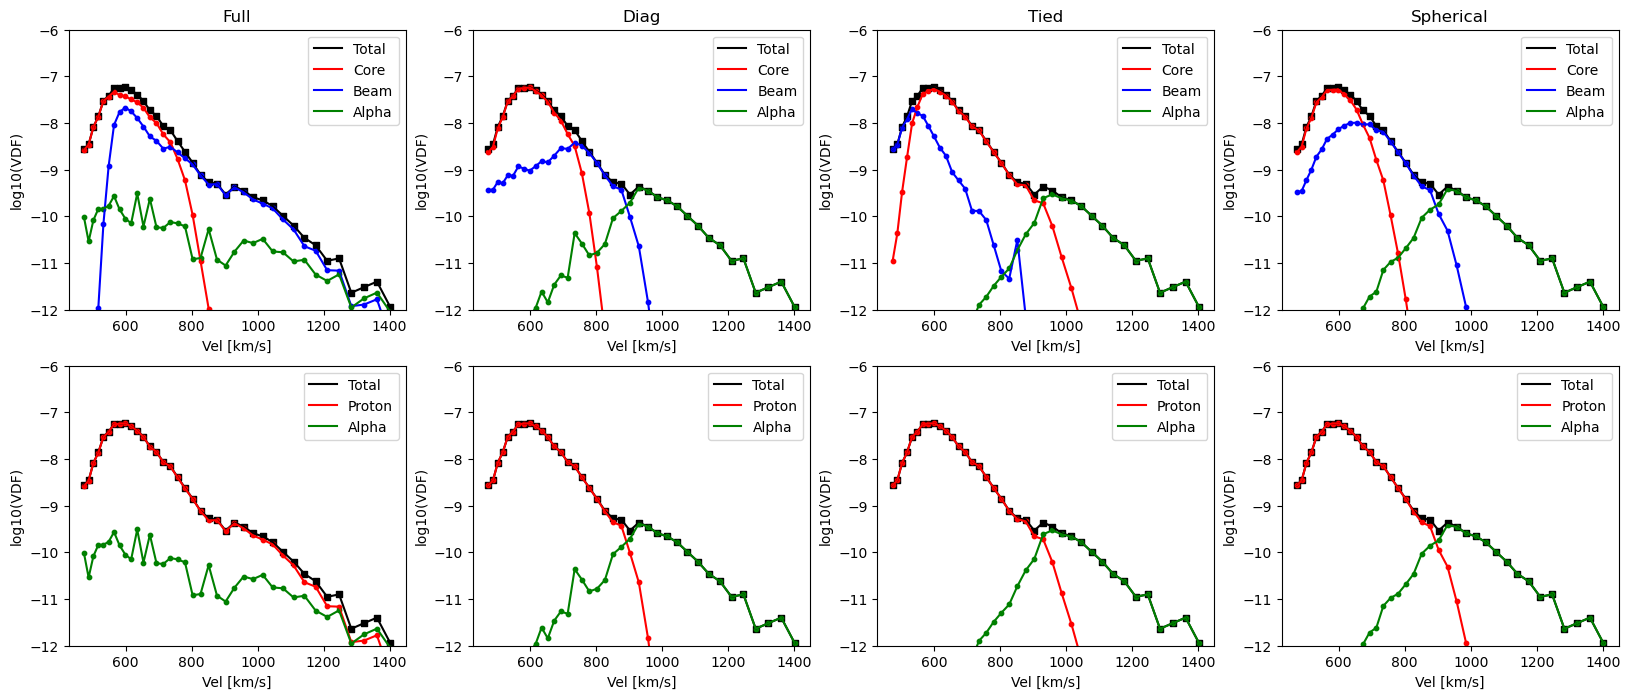

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
# Full 
plot_one(ax[0, 0], ax[1, 0], vdf_2ndcorrected, f_core_full, f_beam_full, f_alpha_full, 'Full')

# diag
plot_one(ax[0, 1], ax[1, 1], vdf_2ndcorrected, f_core_diag, f_beam_diag, f_alpha_diag, 'Diag')

# tied
plot_one(ax[0, 2], ax[1, 2], vdf_2ndcorrected, f_core_tied, f_beam_tied, f_alpha_tied, 'Tied')

# spherical
plot_one(ax[0, 3], ax[1, 3], vdf_2ndcorrected, f_core_spherical, f_beam_spherical, f_alpha_spherical, 'Spherical')

plt.savefig(result_path + '/GMM_all.png')

above 96 set to 0


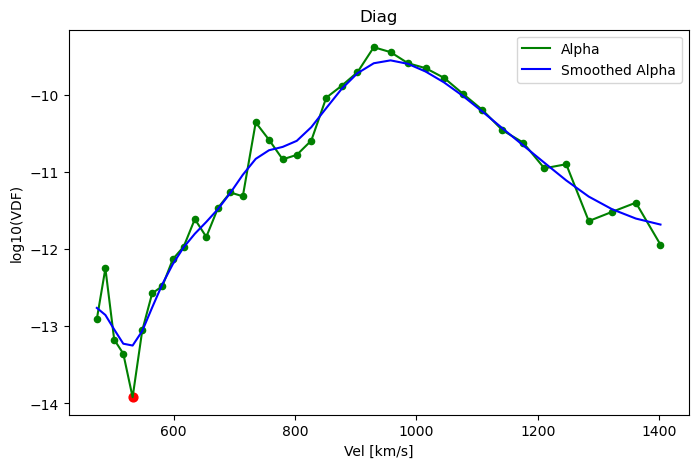

43
above 43 set to 0


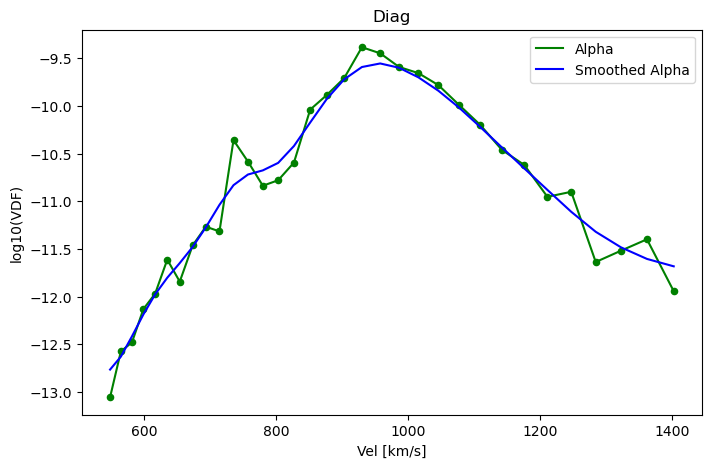

96
above 96 set to 0


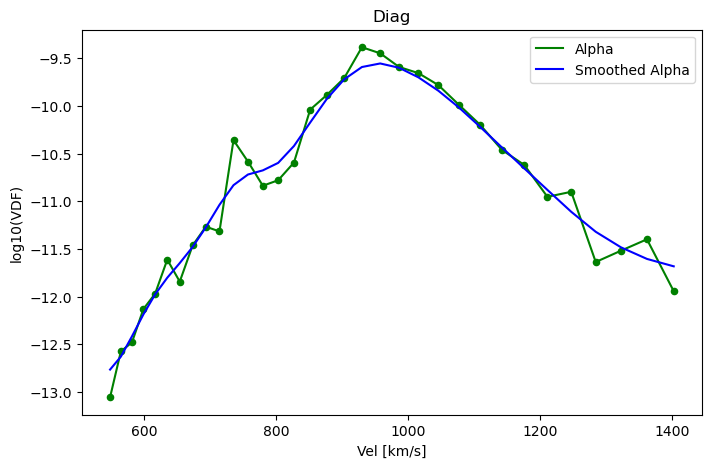

In [20]:
from scipy.signal import savgol_filter

def remove_alpha_low_speed(f_alpha, co_type):
    data = np.sum(f_alpha, axis=(0, 1))
    mask = data > 0
    x = vel[mask]
    y = np.log10(data[mask])
    
    # find the most extreme local minima, that's the dividing index.
    sigma = 1.5
    smoothed_y = gaussian_filter1d(y, sigma)
    local_minima_indices = argrelextrema(smoothed_y, np.less)[0]
    extreme_min_index = None
    if local_minima_indices.size > 0:
        extreme_min_index = local_minima_indices[np.argmin(y[local_minima_indices])]

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, y, label='Alpha', color='green')
    ax.plot(x, smoothed_y, label='Smoothed Alpha', color='blue')
    ax.scatter(x, y, s=20, color='green')
    if extreme_min_index is not None:
        ax.scatter(x[extreme_min_index], y[extreme_min_index], s=40, color='red')
    ax.legend()
    ax.set_title(co_type)
    ax.set_xlabel('Vel [km/s]')
    ax.set_ylabel('log10(VDF)')
    plt.show()
    plt.close()

    # Find the dividing index:
    vels = vel.value
    x_val = x[extreme_min_index].value
    alpha_dividing_idx = len(vels)
    if extreme_min_index is not None:
        alpha_dividing_idx = np.where(vels == x_val)[0][0]

    return alpha_dividing_idx

alpha_dividing_idx = 96
while alpha_dividing_idx > dividing_idx:
    print('above ' + str(alpha_dividing_idx) + ' set to 0') 
    f_alpha_diag[:, :, alpha_dividing_idx:] = 0
    idx_new = remove_alpha_low_speed(f_alpha_diag, 'Diag')
    if idx_new == alpha_dividing_idx:
        break
    print(idx_new)
    alpha_dividing_idx = idx_new

above 96 set to 0


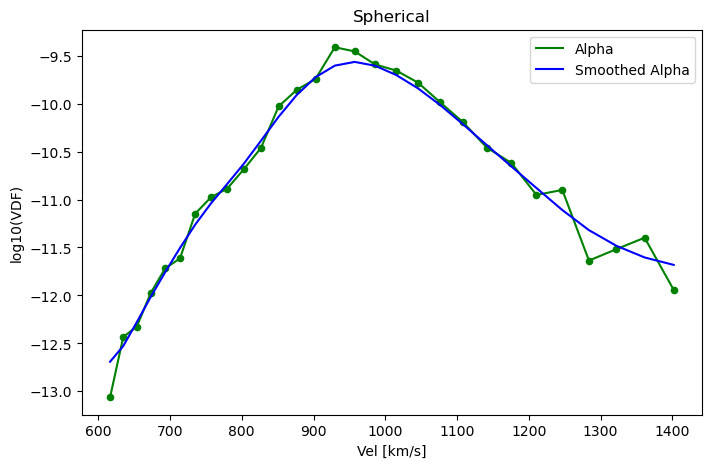

In [21]:
alpha_dividing_idx = 96
while alpha_dividing_idx > dividing_idx:
    print('above ' + str(alpha_dividing_idx) + ' set to 0') 
    f_alpha_spherical[:, :, alpha_dividing_idx:] = 0
    idx_new = remove_alpha_low_speed(f_alpha_spherical, 'Spherical')
    if idx_new == alpha_dividing_idx:
        break
    print(idx_new)
    alpha_dividing_idx = idx_new

In [ ]:
# Save "Diag" and "Spherical" results.
Protons_diag = SolarWindParticle('proton', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3], coord_type='Spherical')
Protons_diag.set_vdf(f_core_diag, 'core')
Protons_diag.set_vdf(f_beam_diag, 'beam')
Alphas_diag = SolarWindParticle('alpha', time=measured_time, magfield=magF_SRF, grid=[theta.value, hi.value, vel.value * 1e3], coord_type='Spherical')
Alphas_diag.set_vdf(f_alpha_diag)

Protons_spherical = SolarWindParticle('proton', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3], coord_type='Spherical')
Protons_spherical.set_vdf(f_core_spherical, 'core')
Protons_spherical.set_vdf(f_beam_spherical, 'beam')
Alphas_spherical = SolarWindParticle('alpha', time=measured_time, magfield=magF_SRF, grid=[theta.value, phi.value, vel.value * 1e3], coord_type='Spherical')
Alphas_spherical.set_vdf(f_alpha_spherical)

In [23]:
# Print the moments to see what the results look like.
Vpcore_diag = cal_bulk_velocity_Spherical(Protons_diag, 'core') / 1e3
Vpbeam_diag = cal_bulk_velocity_Spherical(Protons_diag, 'beam') / 1e3
Valpha_diag = cal_bulk_velocity_Spherical(Alphas_diag) / (np.sqrt(2) * 1e3)
Vpcore_spherical = cal_bulk_velocity_Spherical(Protons_spherical, 'core') / 1e3
Vpbeam_spherical = cal_bulk_velocity_Spherical(Protons_spherical, 'beam') / 1e3
Valpha_spherical = cal_bulk_velocity_Spherical(Alphas_spherical) / (np.sqrt(2) * 1e3)

VpcoreDiagBaligned = rotateVectorIntoFieldAligned(Vpcore_diag[0], Vpcore_diag[1], Vpcore_diag[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpcoreDiagPara, VpcoreDiagPerp = VpcoreDiagBaligned[0], np.sqrt(VpcoreDiagBaligned[1]**2 + VpcoreDiagBaligned[2]**2)
VpbeamDiagBaligned = rotateVectorIntoFieldAligned(Vpbeam_diag[0], Vpbeam_diag[1], Vpbeam_diag[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpbeamDiagPara, VpbeamDiagPerp = VpbeamDiagBaligned[0], np.sqrt(VpbeamDiagBaligned[1]**2 + VpbeamDiagBaligned[2]**2)
ValphaDiagBaligned = rotateVectorIntoFieldAligned(Valpha_diag[0], Valpha_diag[1], Valpha_diag[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
ValphaDiagPara, ValphaDiagPerp = ValphaDiagBaligned[0], np.sqrt(ValphaDiagBaligned[1]**2 + ValphaDiagBaligned[2]**2)

VpcoreSphericalBaligned = rotateVectorIntoFieldAligned(Vpcore_spherical[0], Vpcore_spherical[1], Vpcore_spherical[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpcoreSphericalPara, VpcoreSphericalPerp = VpcoreSphericalBaligned[0], np.sqrt(VpcoreSphericalBaligned[1]**2 + VpcoreSphericalBaligned[2]**2)
VpbeamSphericalBaligned = rotateVectorIntoFieldAligned(Vpbeam_spherical[0], Vpbeam_spherical[1], Vpbeam_spherical[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
VpbeamSphericalPara, VpbeamSphericalPerp = VpbeamSphericalBaligned[0], np.sqrt(VpbeamSphericalBaligned[1]**2 + VpbeamSphericalBaligned[2]**2)
ValphaSphericalBaligned = rotateVectorIntoFieldAligned(Valpha_spherical[0], Valpha_spherical[1], Valpha_spherical[2], Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)
ValphaSphericalPara, ValphaSphericalPerp = ValphaSphericalBaligned[0], np.sqrt(ValphaSphericalBaligned[1]**2 + ValphaSphericalBaligned[2]**2)

# Calculate the angle between drif speeds with respect to the magnetic field.
Theta_PCore_Beam_Diag = np.arctan((VpbeamDiagPerp - VpcoreDiagPerp) / (VpbeamDiagPara - VpcoreDiagPara)) * 180 / np.pi
Theta_PCore_Alpha_Diag = np.arctan((ValphaDiagPerp - VpcoreDiagPerp) / (ValphaDiagPara - VpcoreDiagPara)) * 180 / np.pi

Theta_PCore_Beam_Spherical = np.arctan((VpbeamSphericalPerp - VpcoreSphericalPerp) / (VpbeamSphericalPara - VpcoreSphericalPara)) * 180 / np.pi
Theta_PCore_Alpha_Spherical = np.arctan((ValphaSphericalPerp - VpcoreSphericalPerp) / (ValphaSphericalPara - VpcoreSphericalPara)) * 180 / np.pi

print('Diag')
print('=================================')
print('Vpcore:', VpcoreDiagPara, VpcoreDiagPerp)
print('Vpbeam:', VpbeamDiagPara, VpbeamDiagPerp)
print('Vpalpha:', ValphaDiagPara, ValphaDiagPerp)

print('Spherical')
print("=================================")
print('Vpcore:', VpcoreSphericalPara, VpcoreSphericalPerp)
print('Vpbeam:', VpbeamSphericalPara, VpbeamSphericalPerp)
print('Vpalpha:', ValphaSphericalPara, ValphaSphericalPerp)

print("Beam-Core Theta Diag: ", Theta_PCore_Beam_Diag)
print("Alpha-Core Theta Diag: ", Theta_PCore_Alpha_Diag)
print("Beam-Core Theta Spherical: ", Theta_PCore_Beam_Spherical)
print("Alpha-Core Theta Spherical: ", Theta_PCore_Alpha_Spherical)

Diag
Vpcore: 459.22357 390.31384
Vpbeam: 578.59937 421.9586
Vpalpha: 548.7930092225631 423.1670301588698
Spherical
Vpcore: 451.01685 383.62582
Vpbeam: 524.5656 419.9672
Vpalpha: 549.8814751621314 424.34352744110936
Beam-Core Theta Diag:  14.846781
Alpha-Core Theta Diag:  20.142539771293798
Beam-Core Theta Spherical:  26.294554
Alpha-Core Theta Spherical:  22.38446498316177


In [24]:
# Compute the norms of Vpcore and Valpha.
norm_Vpcore_diag = np.linalg.norm(Vpcore_diag)
norm_Valpha_diag = np.linalg.norm(Valpha_diag)
norm_Vpcore_spherical = np.linalg.norm(Vpcore_spherical)
norm_Valpha_spherical = np.linalg.norm(Valpha_spherical)

# First criterion: Ensure norm(Vpcore) < norm(Valpha)
if norm_Vpcore_diag > norm_Valpha_diag and norm_Vpcore_spherical > norm_Valpha_spherical:
    print("Error: Both Diag and Spherical have Vpcore > Valpha.")
elif norm_Vpcore_diag < norm_Valpha_diag and norm_Vpcore_spherical > norm_Valpha_spherical:
    print("Diag satisfies Vpcore < Valpha, selecting Diag.")
    Protons_current = Protons_diag
    Alphas_current = Alphas_diag
elif norm_Vpcore_diag > norm_Valpha_diag and norm_Vpcore_spherical < norm_Valpha_spherical:
    print("Spherical satisfies Vpcore < Valpha, selecting Spherical.")
    Protons_current = Protons_spherical
    Alphas_current = Alphas_spherical
else:
    # Both satisfy the condition, use Theta_PCore_Alpha comparison
    if np.abs(Theta_PCore_Alpha_Diag) < np.abs(Theta_PCore_Alpha_Spherical):
        print("Diag is better.")
        Protons_current = Protons_diag
        Alphas_current = Alphas_diag
    else:
        print("Spherical is better.")
        Protons_current = Protons_spherical
        Alphas_current = Alphas_spherical

Protons_current = Protons_spherical
Alphas_current = Alphas_spherical

#hhmmss = timeslice.strftime("%H%M%S")
save_pickle(path=f'result/SO/{yymmdd}/Particles/Ions/{hhmmss}/Protons.pkl', data=Protons_current)
save_pickle(path=f'result/SO/{yymmdd}/Particles/Ions/{hhmmss}/Alphas.pkl', data=Alphas_current)

#save_pickle(path=f'result/SO/{yymmdd}/Particles/Ions/0_initial/Protons.pkl', data=Protons_current)
#save_pickle(path=f'result/SO/{yymmdd}/Particles/Ions/0_initial/Alphas.pkl', data=Alphas_current)

Diag is better.
